<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap12/Trial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"!

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ufdt949c
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-t81rczxj
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap12/'
os.chdir(folder)
print(os.getcwd()) 
for items in os.listdir(folder):
   print(items)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap12
template
Trial1.ipynb
Trial2.ipynb
Trial5.ipynb


In [0]:
import torch
import torchvision
from template import TinyImageNet
from template import DatasetFromSubset
from template import download_extract
from template import Albumentationtransform
from template import chap12ResNet

In [5]:
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
fileName = "tiny-imagenet-200.zip"
download_extract.download_images(IMAGES_URL)

In [6]:
def get_classes(download_folder):
    classes = []
    wnids = open(os.path.join(download_folder,"wnids.txt"), "r")
    for line in wnids:
        classes.append(line.strip())
    return classes

print(folder)
download_folder = folder + 'tiny-imagenet-200/'
if (os.path.isdir(download_folder)==False):
    print(download_folder," does not exist")
else :    
    classes = get_classes(download_folder)
    print(classes)

/content/gdrive/My Drive/school_of_ai/chap12/
['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02

In [0]:
from torch.utils.data import Dataset, random_split
def TinyImageNetDataSet(train_split = 70,test_transforms = None,train_transforms = None):
  dataset = TinyImageNet.TinyImageNet(classes,download_folder)
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset.DatasetFromSubset(train_set, transform=train_transforms)
  test_dataset = DatasetFromSubset.DatasetFromSubset(val_set, transform=test_transforms)
  
  return train_dataset, test_dataset,classes

In [8]:
import albumentations as A
import cv2
train_transform = Albumentationtransform.AlbumentationTransforms([                              
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = Albumentationtransform.AlbumentationTransforms([A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

In [0]:
def load(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1
	cuda = torch.cuda.is_available()
	torch.manual_seed(SEED)
	if cuda:
			torch.cuda.manual_seed(SEED)
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	return  trainloader, testloader

In [0]:
trainloader, testloader = load(train_dataset,test_dataset,batch_size=256)

In [20]:
!pip install torchsummary
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = chap12ResNet.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.2, total_steps=None, epochs=30, steps_per_epoch=1, pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [22]:
from template import train_test
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,50,scheduler,batch_scheduler=False,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap12/newtinymodel.pt")

Loss=1.0336960554122925 Batch_id=253 Accuracy=75.77:  84%|████████▍ | 253/301 [07:50<01:28,  1.85s/it]

Loss=1.0336960554122925 Batch_id=253 Accuracy=75.77:  84%|████████▍ | 254/301 [07:50<01:26,  1.85s/it]

Loss=1.0733064413070679 Batch_id=254 Accuracy=75.75:  84%|████████▍ | 254/301 [07:52<01:26,  1.85s/it]

Loss=1.0733064413070679 Batch_id=254 Accuracy=75.75:  85%|████████▍ | 255/301 [07:52<01:25,  1.85s/it]

Loss=0.9155145883560181 Batch_id=255 Accuracy=75.75:  85%|████████▍ | 255/301 [07:54<01:25,  1.85s/it]

Loss=0.9155145883560181 Batch_id=255 Accuracy=75.75:  85%|████████▌ | 256/301 [07:54<01:23,  1.85s/it]

Loss=0.9960403442382812 Batch_id=256 Accuracy=75.74:  85%|████████▌ | 256/301 [07:56<01:23,  1.85s/it]

Loss=0.9960403442382812 Batch_id=256 Accuracy=75.74:  85%|████████▌ | 257/301 [07:56<01:21,  1.85s/it]

Loss=0.9128283858299255 Batch_id=257 Accuracy=75.76:  85%|████████▌ | 257/301 [07:58<01:21,  1.85s/it]

Loss=0.9128283858299255 Batch_id=257 Accuracy=75.76:  86%|██████


Test set: Average loss: 0.0075, Accuracy: 18890/33000 (57.24%)

accuracy increased, Saving model....




  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 29 LR: 0.011900000000000022




Loss=0.865988552570343 Batch_id=0 Accuracy=75.00:   0%|          | 0/301 [00:02<?, ?it/s]

Loss=0.865988552570343 Batch_id=0 Accuracy=75.00:   0%|          | 1/301 [00:02<12:17,  2.46s/it]

Loss=0.7604125142097473 Batch_id=1 Accuracy=77.73:   0%|          | 1/301 [00:04<12:17,  2.46s/it]

Loss=0.7604125142097473 Batch_id=1 Accuracy=77.73:   1%|          | 2/301 [00:04<11:21,  2.28s/it]

Loss=0.8025633096694946 Batch_id=2 Accuracy=77.86:   1%|          | 2/301 [00:06<11:21,  2.28s/it]

Loss=0.8025633096694946 Batch_id=2 Accuracy=77.86:   1%|          | 3/301 [00:06<10:40,  2.15s/it]

KeyboardInterrupt: ignored

In [23]:
from template import evaluate
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 55 %


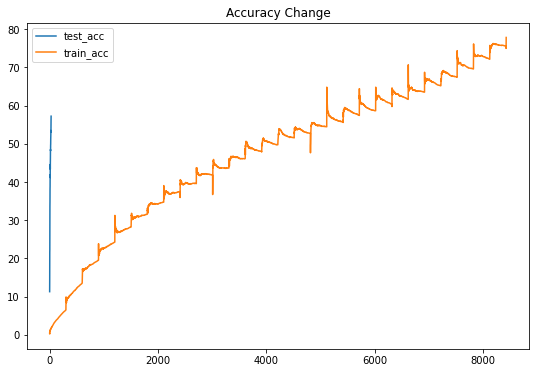

In [24]:
import matplotlib.pyplot as plt
def plot_curve(curves,title,Figsize = (7,7)):
    fig = plt.figure(figsize=Figsize)
    ax = plt.subplot()
    for curve in curves:
        ax.plot(curve[0], label=curve[1])
        plt.title(title)
    ax.legend()
    plt.show()
curves = [(train_test.test_acc,"test_acc"),(train_test.train_acc,"train_acc")]
plot_curve(curves,"Accuracy Change",Figsize = (9,6))